In [28]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns=1000

# Load data

In [29]:
df = pd.read_csv('/gh/data/hcmst/1_cleaned.csv', index_col=0)
df.head(4)

,age,education,race,sex,household_size,house_type,income,marital_status,in_metro,usa_region,house_payment,N_child,work,has_internet,has_gay_friendsfam,politics,religion,in_relationship,partner_age,N_minutes_survey,is_lgb,is_married,partner_race,partner_religion,partner_education,USA_raised,N_marriages,cohabit,age_first_met,age_relationship_begin,age_married,relative_income,same_high_school,same_college,same_hometown,age_difference,relationship_quality,met_online,met_friends,met_family,met_work,relationship_excellent,is_not_working,has_gay_friends,has_gay_family,religion_is_christian,religion_is_none,partner_religion_is_christian,partner_religion_is_none
0,52,bachelor's degree or higher,hispanic,female,2,apartment,22250.0,living with partner,True,midwest,rent,0,working - as a paid employee,True,"yes, friends",democrat,catholic,True,48.0,20,True,False,white,"protestant (e.g. methodist, lutheran, presbyte...",some college,True,1,False,45.0,45.0,NaN,less,False,False,False,4.0,good,True,False,False,False,False,False,True,False,True,False,False,False
1,28,bachelor's degree or higher,white,female,2,apartment,45000.0,living with partner,True,west,rent,0,working - as a paid employee,True,"yes, both",democrat,jewish,True,30.0,13,True,True,white,none,bachelor's degree or higher,True,1,False,19.0,20.0,23.0,more,False,True,False,2.0,good,False,True,False,False,False,False,True,True,False,False,False,True
2,49,high school,black,female,4,apartment,37250.0,never married,True,south,rent,1,working - as a paid employee,True,"yes, both",democrat,baptist-any denomination,False,NaN,0,False,False,NaN,NaN,less than high school,False,NaN,False,NaN,NaN,NaN,NaN,False,False,False,NaN,NaN,False,False,False,False,False,False,True,True,True,False,False,False
3,31,some college,white,male,1,apartment,45000.0,never married,True,south,owned,0,working - as a paid employee,True,"yes, both",democrat,"other non-christian, please specify:",True,40.0,9,True,False,white,"other non-christian, please specify",high school,True,0,False,23.0,23.0,NaN,more,False,False,False,9.0,good,True,True,False,False,False,False,True,True,False,False,False,False


# Make some new features

In [30]:
df['met_to_marriage_years'] = df['age_married'] - df['age_first_met']
df['relationship_to_marriage_years'] = df['age_married'] - df['age_relationship_begin']
df['years_since_marriage'] = df['age'] - df['age_married']
df['same_race'] = df['race'] == df['partner_race']
df['same_religion'] = df['religion'] == df['partner_religion']
df['same_education'] = df['education'] == df['partner_education']

# Choose target

In [31]:
df.dropna(subset=['relationship_quality'], inplace=True)
y = df['relationship_excellent'].values
df.drop(['relationship_excellent', 'relationship_quality'], axis=1, inplace=True)

# Make model

In [78]:
# Model settings
model_config = {
    'algorithm': 'logit',
    'param_grid': {'penalty': ['l1', 'l2'], 'C': np.logspace(-6,3,10)},
#     'algorithm': 'rf',
#     'param_grid': {'n_estimators': [100, 1000], 'max_depth': [5, 7, 9], 'max_features': [.1, .3, .5]},
    'n_folds': 5
}

In [79]:
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler,Imputer

from lime.lime_tabular import LimeTabularExplainer

In [80]:
class DataFrame_Encoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical_cols_=None,numeric_cols_=None):
        self.categorical_cols_ = categorical_cols_
        self.numeric_cols_ = numeric_cols_
    
    def fit(self, df, y=None):
        ### df should be a dataframe that is a mix of categorical and numeric columns
        self.vec_ = DictVectorizer(sparse=False)
        temp_data = df[self.categorical_cols_].astype(str)
        self.vec_.fit(temp_data.to_dict('records'))
        
        self.feature_names_ = list(self.numeric_cols_) + list(self.vec_.feature_names_)
        return self

    def transform(self, df):
        ### df should be a dataframe that is a mix of categorical and numeric columns
        if len(self.categorical_cols_) > 0:
            temp_data = df[self.categorical_cols_].astype(str)
            categorical_data = self.vec_.transform(temp_data.to_dict('records'))
            categorical_df = pd.DataFrame(categorical_data, columns=self.vec_.feature_names_, index=df.index)

            new_data = pd.concat([df[self.numeric_cols_], categorical_df],axis=1)
        else:
            new_data = df.copy()
        return new_data

### Prep model

In [81]:
# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=.2, random_state=0)

# Algorithm type
if model_config['algorithm'] == 'lgbm':
    base_clf = lightgbm.LGBMClassifier(is_unbalance=True, nthread=4)
if model_config['algorithm'] == 'logit':
    base_clf = LogisticRegression(solver='liblinear')
if model_config['algorithm'] == 'rf':
    base_clf = RandomForestClassifier(n_jobs=-1)

# Pipeline
if model_config['algorithm'] == 'rf':
    pipeline = Pipeline([
            ('feature_encoder',DataFrame_Encoder()),
            ('imputer',Imputer()),
            ('clf',base_clf)
    ])
else:
    pipeline = Pipeline([
        ('feature_encoder',DataFrame_Encoder()),
        ('imputer',Imputer()),
        ('scaler',StandardScaler()),
        ('clf',base_clf)
    ])


# Pipeline parameters
string_features = X_train.select_dtypes(include=[object]).columns.values
numeric_features = X_train.select_dtypes(exclude=[object]).columns.values
pipeline.set_params(feature_encoder__categorical_cols_=string_features,
                    feature_encoder__numeric_cols_=numeric_features)

pipeline_params = {}
for key in model_config['param_grid']:
    pipeline_params['clf__'+key] = model_config['param_grid'][key]

### Train model

In [82]:
pipeline

Pipeline(steps=[('feature_encoder', DataFrame_Encoder(categorical_cols_=array(['education', 'race', 'sex', 'house_type', 'marital_status',
       'usa_region', 'house_payment', 'work', 'has_gay_friendsfam',
       'politics', 'religion', 'partner_race', 'partner_religion',
       'partner_education', 'N_marr...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [83]:
pipeline_params

{'clf__C': array([  1.00000000e-06,   1.00000000e-05,   1.00000000e-04,
          1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
          1.00000000e+00,   1.00000000e+01,   1.00000000e+02,
          1.00000000e+03]), 'clf__penalty': ['l1', 'l2']}

In [84]:
clf = GridSearchCV(pipeline, pipeline_params, cv=model_config['n_folds'],
                   n_jobs=4, verbose=4, scoring='roc_auc')
clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] clf__C=1e-06, clf__penalty=l1 ...................................
[CV] clf__C=1e-06, clf__penalty=l1 ...................................
[CV] clf__C=1e-06, clf__penalty=l1 ...................................
[CV] clf__C=1e-06, clf__penalty=l1 ...................................
[CV] clf__C=1e-06, clf__penalty=l1 ...................................
[CV] clf__C=1e-06, clf__penalty=l2 ...................................
[CV] clf__C=1e-06, clf__penalty=l2 ...................................
[CV] clf__C=1e-06, clf__penalty=l2 ...................................


Process ForkPoolWorker-31:
Process ForkPoolWorker-30:
Process ForkPoolWorker-29:
Process ForkPoolWorker-32:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/scott/anaconda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/scott/anaconda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/scott/anaconda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/scott/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/scott/anaconda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/scott/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/scott/anaconda/lib/

KeyboardInterrupt: 

# Evaluate model performance on test set
* Logit 
    * Not great: violin plots of proba mostly overlap
    * AUC = 0.615
    * precision = ??
* RF
    * AUC = 0.636
    * precision = 

### Compute AUC and precision

In [75]:
y_train_pred = [x[1] for x in clf.predict_proba(X_train)]
y_test_pred = [x[1] for x in clf.predict_proba(X_test)]
print('AUC=', roc_auc_score(y_test, y_test_pred))

AUC= 0.635638782577


In [ ]:
frac_flag = .1


/Users/scott/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/scott/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


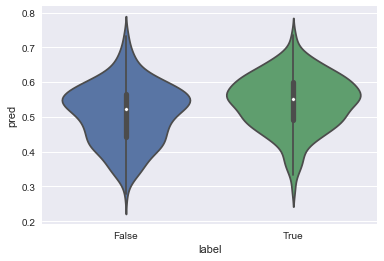

In [68]:
df_y = pd.DataFrame({'label': y_test, 'pred': y_test_pred})
sns.violinplot(y='pred', x='label', data=df_y)